## 1' Addestramento Rete Feed-Forward

In [5]:
import random
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import matplotlib.pyplot as plt

# For reproducibility
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Define the Data Layer
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y).view(-1, 1)  # Reshape to (batch_size, 1) for regression
         
        self.num_features = X.shape[1]
        self.num_classes = 1  # Regression has only one output

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

# Define an improved neural network for regression
class ImprovedFeedForwardRegression(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(ImprovedFeedForwardRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        output = self.fc3(x)
        return output

# Define a function for the training process for regression
def train_model_regression(model, criterion, optimizer, epoch, train_loader, val_loader, device, writer, log_name="model"):
    n_iter = 0
    best_valid_loss = float('inf')
    train_losses = []  # Lista per registrare le perdite durante l'addestramento

    for epoch in range(epoch):
        model.train()
        epoch_loss = 0.0

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            
            optimizer.zero_grad()
            y_pred = model(data)
            loss = criterion(y_pred, targets)
            writer.add_scalar("Loss/train", loss, n_iter)
            loss.backward()
            optimizer.step()
            n_iter += 1

            epoch_loss += loss.item()

        average_loss = epoch_loss / len(train_loader)
        train_losses.append(average_loss)

        labels, y_pred = test_model_regression(model, val_loader, device)
        loss_val = criterion(y_pred, labels)
        writer.add_scalar("Loss/val", loss_val, epoch)
        
        if loss_val.item() < best_valid_loss:
            best_valid_loss = loss_val.item()
            if not os.path.exists('models'):
                os.makedirs('models')
            torch.save(model.state_dict(), 'models/'+log_name)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {average_loss}, Validation Loss: {loss_val.item()}")

    return model, train_losses

# Define a function to evaluate the performance on validation and test sets for regression
def test_model_regression(model, data_loader, device):
    model.eval()
    y_pred = []
    y_test = []
    
    for data, targets in data_loader:
        data, targets = data.to(device), targets.to(device)
        y_pred.append(model(data))
        y_test.append(targets)
    
    y_test = torch.cat(y_test)
    y_pred = torch.cat(y_pred)
    
    return y_test, y_pred

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: {}".format(device))

# Train hyperparameters
num_epochs = 200  # Increase the number of epochs
learning_rate = 0.001  # Adjust the learning rate
batch = 8

# Load data
FILENAME = "train.csv"
df = pd.read_csv(FILENAME)

seed = 42

# Select input variables (X) and output variable (y)
X = df.drop("Year", axis=1).values  # Convert to numpy array
y = df["Year"].values

# Split data
indices = np.arange(X.shape[0])
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=seed)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, random_state=seed)

# Standardize data
train_mean = np.mean(X[train_idx, :], axis=0)
train_std = np.std(X[train_idx, :], axis=0)
X = (X - train_mean) / train_std

# Update normalization with Min-Max scaling
X_min, X_max = X.min(axis=0), X.max(axis=0)
X = (X - X_min) / (X_max - X_min)

# Create dataset
my_dataset = MyDataset(X, y)

# Create subsets and relative dataloaders
train_subset = Subset(my_dataset, train_idx)
train_loader = DataLoader(train_subset, batch_size=batch, shuffle=True)

val_subset = Subset(my_dataset, val_idx)
val_loader = DataLoader(val_subset, batch_size=1)

test_subset = Subset(my_dataset, test_idx)
test_loader = DataLoader(test_subset, batch_size=1)

# Set seed for reproducibility
fix_random(seed)

# Start TensorBoard
writer = SummaryWriter()

# Define the architecture, loss, and optimizer
hidden_size1 = 64  # Increase the size of hidden layers
hidden_size2 = 32
model = ImprovedFeedForwardRegression(my_dataset.num_features, hidden_size1, hidden_size2)
model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Use Adam optimizer

# Learning Rate Scheduling
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# Test before training
y_test, y_pred = test_model_regression(model, test_loader, device)
loss_before_training = criterion(y_pred, y_test)
print("Mean Squared Error before training:", loss_before_training.item())

# Train the model 
trained_model, train_losses = train_model_regression(model, criterion, optimizer, num_epochs, train_loader, val_loader, device, writer)

# Save the best model
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(trained_model.state_dict(), 'models/best_model.pth')

# Load the best model
best_model_path = 'models/best_model.pth'
if os.path.exists(best_model_path):
    trained_model.load_state_dict(torch.load(best_model_path))
    trained_model.to(device)
    print("Model loaded successfully.")
else:
    print("Error: The specified model path does not exist.")

# Test after training
y_test, y_pred = test_model_regression(trained_model, test_loader, device)
mse = mean_squared_error(y_test.detach().numpy(), y_pred.detach().numpy())
mae = mean_absolute_error(y_test.detach().numpy(), y_pred.detach().numpy())
mape = np.mean(np.abs((y_test.detach().numpy() - y_pred.detach().numpy()) / y_test.detach().numpy())) * 100
r2 = r2_score(y_test.detach().numpy(), y_pred.detach().numpy())

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R2 Score: {r2}')

# Visualizza l'andamento delle perdite durante l'addestramento
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Close TensorBoard writer after training
writer.flush()
writer.close()


Device: cpu
Mean Squared Error before training: 3993623.0
Epoch 1/200, Training Loss: 46648.20142439462, Validation Loss: 204.86001586914062
Epoch 2/200, Training Loss: 188.8059060985321, Validation Loss: 168.023681640625
Epoch 3/200, Training Loss: 171.21013638043624, Validation Loss: 186.87545776367188
Epoch 4/200, Training Loss: 162.38897077474957, Validation Loss: 145.03384399414062
Epoch 5/200, Training Loss: 157.30319007454418, Validation Loss: 143.991455078125
Epoch 6/200, Training Loss: 154.425607170212, Validation Loss: 146.33197021484375
Epoch 7/200, Training Loss: 151.5381066572965, Validation Loss: 143.1486053466797
Epoch 8/200, Training Loss: 149.34592184158197, Validation Loss: 133.023193359375
Epoch 9/200, Training Loss: 148.4571129726657, Validation Loss: 131.36949157714844


## 2' Addestramento Rete Feed-Forward

Epoch 1/200, Training Loss: 83.29415411056063, Validation Loss: 78.83091735839844
Epoch 2/200, Training Loss: 83.23836564510704, Validation Loss: 79.16696166992188
Epoch 3/200, Training Loss: 83.19854369825445, Validation Loss: 79.47293853759766
Epoch 4/200, Training Loss: 83.24236762901239, Validation Loss: 83.46881866455078
Epoch 5/200, Training Loss: 83.15667837640156, Validation Loss: 80.85155487060547
Epoch 6/200, Training Loss: 83.22319839658262, Validation Loss: 81.1125717163086
Epoch 7/200, Training Loss: 82.9938308388435, Validation Loss: 79.45433807373047
Epoch 8/200, Training Loss: 83.10278045074595, Validation Loss: 78.68727111816406
Epoch 9/200, Training Loss: 83.06856267320113, Validation Loss: 79.24861907958984
Epoch 10/200, Training Loss: 82.98449863883587, Validation Loss: 80.3268051147461
Epoch 11/200, Training Loss: 83.05915876181544, Validation Loss: 78.9722671508789
Epoch 12/200, Training Loss: 83.11645659643322, Validation Loss: 83.37303924560547
Epoch 13/200, Tra

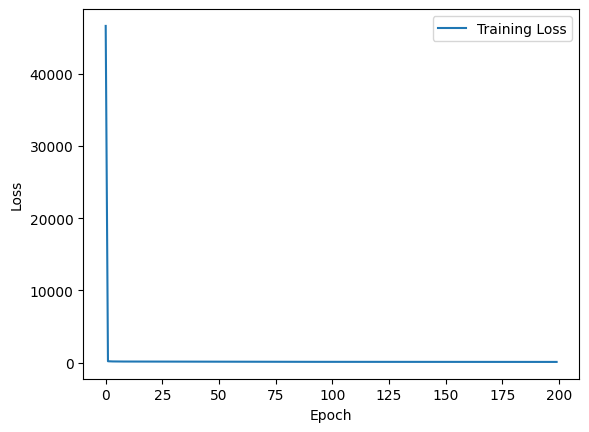

In [4]:
# Definisci un nuovo numero di epoche per il secondo addestramento
num_epochs_second_training = 100

# Definisci un nuovo learning rate per il secondo addestramento
learning_rate_second_training = 0.0005
 
# Crea un nuovo DataLoader usando il modello addestrato e i dati di validazione
new_val_loader = DataLoader(val_subset, batch_size=1)

test_subset = Subset(my_dataset, test_idx)
test_loader = DataLoader(test_subset, batch_size=1)

# Crea un nuovo modello usando i pesi del modello addestrato
second_training_model = ImprovedFeedForwardRegression(my_dataset.num_features, hidden_size1, hidden_size2)
second_training_model.load_state_dict(trained_model.state_dict())  # Carica i pesi del modello addestrato
second_training_model.to(device)

# Crea un nuovo ottimizzatore e schedulatore per il secondo addestramento
optimizer_second_training = torch.optim.Adam(second_training_model.parameters(), lr=learning_rate_second_training)
scheduler_second_training = torch.optim.lr_scheduler.StepLR(optimizer_second_training, step_size=20, gamma=0.1)

# Addestra il modello per il secondo set di epoche
second_trained_model, second_train_losses = train_model_regression(second_training_model, criterion, optimizer_second_training,
                                                                   num_epochs_second_training, train_loader, new_val_loader,
                                                                   device, writer, log_name="second_best_model")

# Salva il modello addestrato durante il secondo addestramento
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(second_trained_model.state_dict(), 'models/second_best_model.pth')

# Test after training
y_test, y_pred = test_model_regression(second_trained_model, test_loader, device)
mse = mean_squared_error(y_test.detach().numpy(), y_pred.detach().numpy())
mae = mean_absolute_error(y_test.detach().numpy(), y_pred.detach().numpy())
mape = np.mean(np.abs((y_test.detach().numpy() - y_pred.detach().numpy()) / y_test.detach().numpy())) * 100
r2 = r2_score(y_test.detach().numpy(), y_pred.detach().numpy())

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R2 Score: {r2}')

# Visualizza l'andamento delle perdite durante l'addestramento
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Close TensorBoard writer after training
writer.flush()
writer.close()

# Chiudi TensorBoard writer dopo il secondo addestramento
writer.flush()
writer.close()


## 3' Addestramento Rete Feed-Forward

Epoch 1/200, Training Loss: 80.80880485083736, Validation Loss: 78.08880615234375
Epoch 2/200, Training Loss: 80.83232149420024, Validation Loss: 78.05994415283203
Epoch 3/200, Training Loss: 80.83213390020096, Validation Loss: 78.02676391601562
Epoch 4/200, Training Loss: 80.83551536172945, Validation Loss: 78.0430908203125
Epoch 5/200, Training Loss: 80.8171619008752, Validation Loss: 78.27518463134766
Epoch 6/200, Training Loss: 80.81114969350921, Validation Loss: 78.71178436279297
Epoch 7/200, Training Loss: 80.81904490711172, Validation Loss: 78.0256118774414
Epoch 8/200, Training Loss: 80.81076689574601, Validation Loss: 79.28778076171875
Epoch 9/200, Training Loss: 80.81741862528929, Validation Loss: 78.02340698242188
Epoch 10/200, Training Loss: 80.81379183222768, Validation Loss: 78.02989196777344
Epoch 11/200, Training Loss: 80.82158438491906, Validation Loss: 78.1330795288086
Epoch 12/200, Training Loss: 80.83229897833442, Validation Loss: 78.01941680908203
Epoch 13/200, Tra

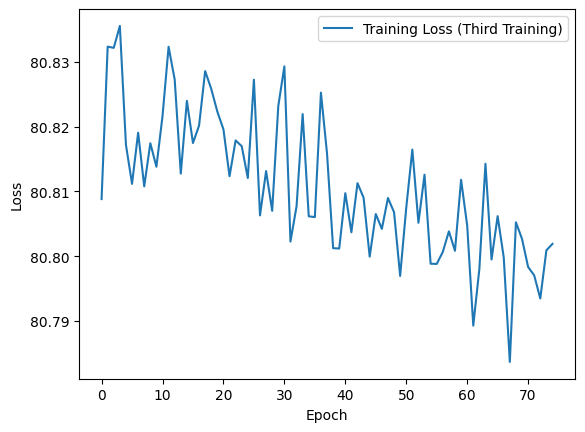

In [ ]:
# Definisci un nuovo numero di epoche per il terzo addestramento
num_epochs_third_training = 75

# Definisci un nuovo learning rate per il terzo addestramento
learning_rate_third_training = 0.000005

# Crea un nuovo DataLoader usando il modello addestrato e i dati di validazione
new_val_loader_third_training = DataLoader(val_subset, batch_size=1)

# Crea un nuovo modello usando i pesi del modello addestrato durante il secondo addestramento
third_training_model = ImprovedFeedForwardRegression(my_dataset.num_features, hidden_size1, hidden_size2)
third_training_model.load_state_dict(second_trained_model.state_dict())  # Carica i pesi del modello addestrato durante il secondo addestramento
third_training_model.to(device)

# Crea un nuovo ottimizzatore e schedulatore per il terzo addestramento
optimizer_third_training = torch.optim.Adam(third_training_model.parameters(), lr=learning_rate_third_training)
scheduler_third_training = torch.optim.lr_scheduler.StepLR(optimizer_third_training, step_size=15, gamma=0.1)

# Addestra il modello per il terzo set di epoche
third_trained_model, third_train_losses = train_model_regression(third_training_model, criterion, optimizer_third_training,
                                                                   num_epochs_third_training, train_loader, new_val_loader_third_training,
                                                                   device, writer, log_name="third_best_model")

# Salva il modello addestrato durante il terzo addestramento
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(third_trained_model.state_dict(), 'models/third_best_model.pth')

# Test dopo il terzo addestramento
y_test_third, y_pred_third = test_model_regression(third_trained_model, test_loader, device)
mse_third = mean_squared_error(y_test_third.detach().numpy(), y_pred_third.detach().numpy())
mae_third = mean_absolute_error(y_test_third.detach().numpy(), y_pred_third.detach().numpy())
mape_third = np.mean(np.abs((y_test_third.detach().numpy() - y_pred_third.detach().numpy()) / y_test_third.detach().numpy())) * 100
r2_third = r2_score(y_test_third.detach().numpy(), y_pred_third.detach().numpy())

print(f'Mean Squared Error (MSE) after the third training: {mse_third}')
print(f'Mean Absolute Error (MAE) after the third training: {mae_third}')
print(f'Mean Absolute Percentage Error (MAPE) after the third training: {mape_third}')
print(f'R2 Score after the third training: {r2_third}')

# Visualizza l'andamento delle perdite durante il terzo addestramento
plt.plot(third_train_losses, label='Training Loss (Third Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Chiudi TensorBoard writer dopo il terzo addestramento
writer.flush()
writer.close()
